In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from benchmark_mae.evaluate import edge_roc_curve
from minstrel.util import rank_hits
from itertools import product
from skbio.stats.composition import clr, centralize
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors

from benchmark_mae.generators import ground_truth_edges
from benchmark_mae.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
import yaml
%matplotlib inline

In [38]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
iteration = '1_a'

In [39]:
results_dir = '../results/test_effect_size_benchmark15'
with open('%s/test_effect_params15.yaml' % results_dir, 'r') as f:
    effect_params = yaml.load(f)

sample_ids = effect_params['samples']
modes = effect_params['modes']
tools = ['deep_mae', 'pearson', 'spearman']

In [40]:
ids = list(product(tools, modes, sample_ids))
fnames = list(map(lambda x: '.'.join(x) + '.results', ids))

In [41]:
df = pd.DataFrame(ids, index=fnames, columns=['tools', 'modes', 'samples'])

In [42]:
kmax=40

Deep learning ranks

In [43]:
sample = sample_ids[0] 
tool = tools[0]
a_fname = 'deep_mae.rel.%s.results' % iteration
r_fname = 'deep_mae.abs.%s.results' % iteration
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T
abs_ranks['type'] = list(map(lambda x: x.split('_')[0], abs_ranks.index))

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

(0.87688756011624003, 0.0)

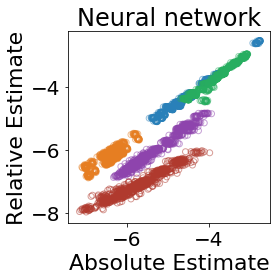

In [51]:
fig, ax = plt.subplots(figsize=(4, 4))    

type_colors = {'SA': '#B03A2E',
               'F': '#2980B9',
               'P': '#27AE60',
               'SG': '#8E44AD',
               'I': '#E67E22'
              }

rel_ranks['type'] = list(map(lambda x: x.split('_')[0], rel_ranks.index))
for t in np.unique(rel_ranks.type):
    a = abs_ranks.loc[abs_ranks.type==t].values[:, :-1]
    r = rel_ranks.loc[rel_ranks.type==t].values[:, :-1]    
    ax.scatter(np.ravel(a), np.ravel(r), label=t, alpha=0.5, 
               facecolor='none',
               edgecolor=type_colors[t])

    
fontsize = 22
labelsize = 20
ax.set_xlabel('Absolute Estimate', fontsize=fontsize)   
ax.set_ylabel('Relative Estimate', fontsize=fontsize)       
#ax.legend(prop={'size': 20}, loc=2)
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.set_title('Neural network', fontsize=fontsize+2)
locator=MaxNLocator(prune='both', nbins=4)
ax.xaxis.set_major_locator(locator)
ax.yaxis.set_major_locator(locator)


plt.tight_layout()
fig.savefig('../results/autoencoder_ranks.png')

pearsonr(abs_ranks.values[:, :-1].ravel(), rel_ranks.values[:, :-1].ravel())

In [20]:
rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [21]:
metabolites = load_table(
    os.path.join(results_dir, 'table.rel.metabolites.1_a.biom')
).to_dataframe().T

microbes = load_table(
    os.path.join(results_dir, 'table.rel.microbes.1_a.biom')
).to_dataframe().T

edges = ground_truth_edges(microbes, metabolites)

In [22]:
mae_pos, mae_neg = _edge_roc_curve(rel_ranks, edges, axis=1, k_max=kmax)

In [23]:
mae_pos['TPR'] = mae_pos.apply(sensitivity, axis=1)
mae_pos['TNR'] = mae_pos.apply(specificity, axis=1)

Spearman ranks

(0.0080076875381335701, 0.61264574269927152)

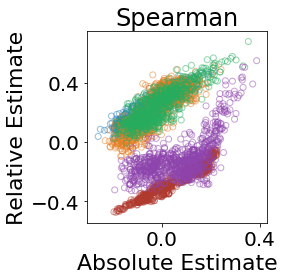

In [52]:
from cycler import cycler
fig, ax = plt.subplots(figsize=(4, 4))    

sample = sample_ids[0] 
tool = tools[0]
a_fname = 'spearman.rel.%s.results' % iteration
r_fname = 'spearman.abs.%s.results' % iteration
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T
abs_ranks['type'] = list(map(lambda x: x.split('_')[0], abs_ranks.index))

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

rel_ranks['type'] = list(map(lambda x: x.split('_')[0], rel_ranks.index))
for t in np.unique(rel_ranks.type):
    a = abs_ranks.loc[abs_ranks.type==t].values[:, :-1]
    r = rel_ranks.loc[rel_ranks.type==t].values[:, :-1]    
    ax.scatter(np.ravel(a), np.ravel(r), alpha=0.5, 
               facecolor='none', linewidth=1, edgecolor=type_colors[t])    
    

ax.set_xlabel('Absolute Estimate', fontsize=fontsize)   
ax.set_ylabel('Relative Estimate', fontsize=fontsize)       
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.set_title('Spearman', fontsize=fontsize+2)

locator=MaxNLocator(prune='both', nbins=4)
ax.xaxis.set_major_locator(locator)
ax.yaxis.set_major_locator(locator)

plt.tight_layout()
fig.savefig('../results/spearman_ranks.png')
pearsonr(abs_ranks.values[:, :-1].ravel(), rel_ranks.values[:, :-1].ravel())

In [53]:
rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [54]:
spear_pos, spear_neg = _edge_roc_curve(rel_ranks, edges, k_max=kmax)

In [55]:
spear_pos['TPR'] = spear_pos.apply(sensitivity, axis=1)
spear_pos['TNR'] = spear_pos.apply(specificity, axis=1)

Pearson

(0.13426460919561847, 1.4938656007827246e-17)

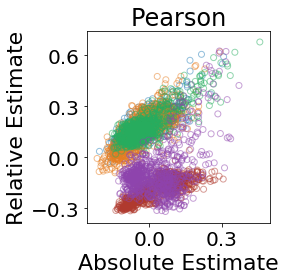

In [56]:
fig, ax = plt.subplots(figsize=(4, 4))    

sample = sample_ids[0] 
tool = tools[0]
a_fname = 'pearson.rel.%s.results' % iteration
r_fname = 'pearson.abs.%s.results' % iteration
edge_file = '%s/edges.%s.txt' % (results_dir, sample)
rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T
#abs_ranks = pd.DataFrame(clr(centralize(softmax(abs_ranks))),
#                         index=abs_ranks.index, 
#                         columns=abs_ranks.columns)
abs_ranks['type'] = list(map(lambda x: x.split('_')[0], abs_ranks.index))

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

rel_ranks['type'] = list(map(lambda x: x.split('_')[0], rel_ranks.index))
for t in np.unique(rel_ranks.type):
    a = abs_ranks.loc[abs_ranks.type==t].values[:, :-1]
    r = rel_ranks.loc[rel_ranks.type==t].values[:, :-1]    
    ax.scatter(np.ravel(a), np.ravel(r), alpha=0.5, 
               facecolor='none', linewidth=1, edgecolor=type_colors[t])    

ax.set_xlabel('Absolute Estimate', fontsize=fontsize)   
ax.set_ylabel('Relative Estimate', fontsize=fontsize)       
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.set_title('Pearson', fontsize=fontsize+2)

locator=MaxNLocator(prune='both', nbins=4)
ax.xaxis.set_major_locator(locator)
ax.yaxis.set_major_locator(locator)
plt.tight_layout()

fig.savefig('../results/pearson_ranks.png')

pearsonr(abs_ranks.values[:, :-1].ravel(), rel_ranks.values[:, :-1].ravel())

In [57]:
rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T

In [58]:
pear_pos, pear_neg = _edge_roc_curve(rel_ranks, edges, k_max=kmax)

In [59]:
pear_pos['TPR'] = pear_pos.apply(sensitivity, axis=1)
pear_pos['TNR'] = pear_pos.apply(specificity, axis=1)

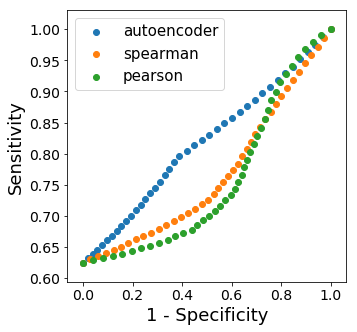

In [60]:
fontsize = 18
labelsize = 14
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(1-mae_pos['TPR'], mae_pos['TNR'], label='autoencoder')
ax.scatter(1-spear_pos['TPR'], spear_pos['TNR'], label='spearman')
ax.scatter(1-pear_pos['TPR'], pear_pos['TNR'], label='pearson')
ax.xaxis.set_tick_params(labelsize=labelsize)
ax.yaxis.set_tick_params(labelsize=labelsize)
ax.legend(prop={'size': 15})
ax.set_xlabel('1 - Specificity', fontsize=fontsize)
ax.set_ylabel('Sensitivity', fontsize=fontsize)
fig.savefig('../results/effect_size_roc.png')
fig.savefig('../results/effect_size_roc.pdf')

In [61]:
a_fname = 'pearson.rel.%s.results' % iteration
r_fname = 'pearson.abs.%s.results' % iteration

rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T
pearsonr(abs_ranks.values.ravel(), rel_ranks.values.ravel())

(0.13426460919561864, 1.493865600782385e-17)

In [62]:
a_fname = 'spearman.rel.%s.results' % iteration
r_fname = 'spearman.abs.%s.results' % iteration

rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T
pearsonr(abs_ranks.values.ravel(), rel_ranks.values.ravel())

(0.0080076875381335406, 0.61264574269927152)

In [63]:
a_fname = 'deep_mae.rel.%s.results' % iteration
r_fname = 'deep_mae.abs.%s.results' % iteration

rank_file = os.path.join(results_dir, a_fname)
abs_ranks = pd.read_table(rank_file, index_col=0).T

rank_file = os.path.join(results_dir, r_fname)
rel_ranks = pd.read_table(rank_file, index_col=0).T
pearsonr(abs_ranks.values.ravel(), rel_ranks.values.ravel())

(0.87688756011623792, 0.0)

In [ ]:
plt.scatter(abs_ranks.values.ravel(), rel_ranks.values.ravel())

In [ ]:
1e-400